In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle/

In [ ]:
! cp '/content/drive/MyDrive/Kaggle/kaggle.json' ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:19<00:00, 131MB/s]
100% 2.29G/2.29G [00:19<00:00, 127MB/s]


In [ ]:
! unzip /content/chest-xray-pneumonia.zip -d pneumonia_data

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: pneumonia_data/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: pneumonia_data/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: pneumonia_data/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: pneumonia_data/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: pneumonia_data/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: pneumonia_data/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: pneumonia_data/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: pneumonia_data/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: pneumonia_data/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: pneumonia_data/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: pneumonia_data/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: pneumonia_data/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: pneumonia_data/chest

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pathlib

In [ ]:
data_path='/content/drive/MyDrive/Kaggle/pneumonia_data/chest_xray'
train_dir=os.path.join(data_path,'train')
test_dir=os.path.join(data_path,'test')
train_dir = pathlib.Path(train_dir)
test_dir = pathlib.Path(test_dir)

Category: NORMAL
Example image path: /content/drive/MyDrive/Kaggle/pneumonia_data/chest_xray/train/NORMAL/IM-0519-0001-0002.jpeg


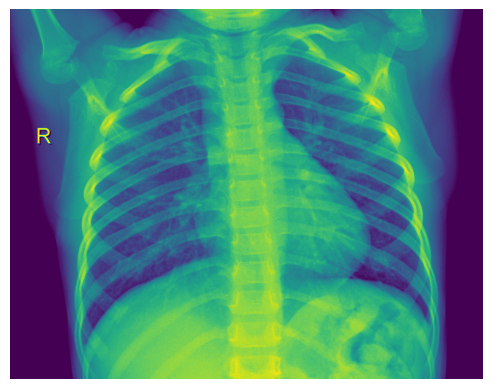

Category: PNEUMONIA
Example image path: /content/drive/MyDrive/Kaggle/pneumonia_data/chest_xray/train/PNEUMONIA/person59_bacteria_281.jpeg


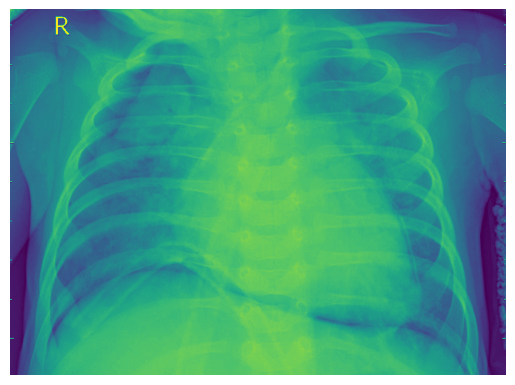

In [ ]:
# List all subdirectories in the data directory
subdirectories = [x for x in train_dir.iterdir() if x.is_dir()]

# Iterate over each subdirectory
for subdirectory in subdirectories:
    # List all image files in the subdirectory
    image_files = list(subdirectory.glob('*'))

    # Print the category (subdirectory name)
    print("Category:", subdirectory.name)

    # Print the path of the first image file in the category
    print("Example image path:", image_files[0])
    # Display the image
    image = Image.open(str(image_files[0]))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [ ]:
img_height, img_width = 224, 224
batch_size = 32

# Create TensorFlow dataset for training
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 5216 files belonging to 2 classes.


In [ ]:
# Create TensorFlow dataset for test
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 624 files belonging to 2 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


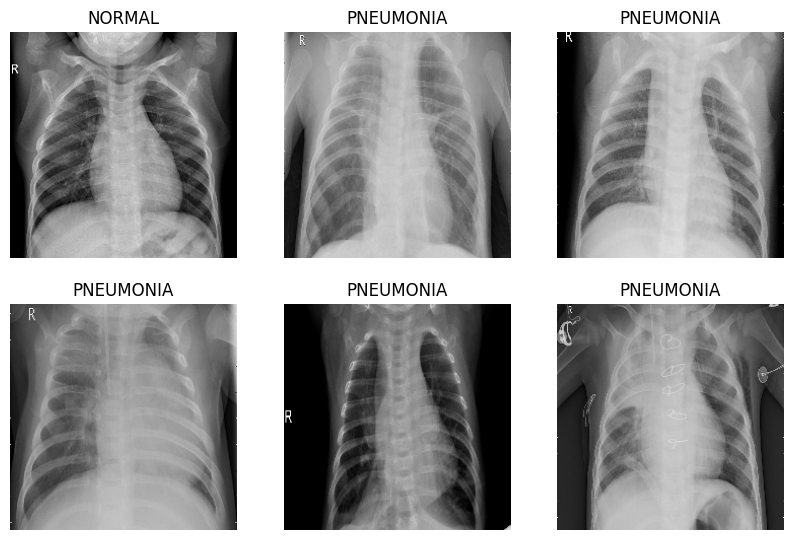

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='viridis')
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [ ]:
VGG19_model = Sequential()

pretrained_model = tf.keras.applications.VGG19(include_top=False,
                                               input_shape=(224, 224, 3),
                                               pooling='avg',
                                               classes=2,
                                               weights='imagenet')

for layer in pretrained_model.layers:
    layer.trainable = False

VGG19_model.add(pretrained_model)
VGG19_model.add(Flatten())
VGG19_model.add(Dense(512, activation='relu'))
VGG19_model.add(Dense(128, activation='relu'))
VGG19_model.add(Dense(32, activation='relu'))
VGG19_model.add(Dense(1, activation='sigmoid'))

In [ ]:
VGG19_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 module_wrapper_3 (ModuleWr  (None, 512)               0         
 apper)                                                          
                                                                 
 module_wrapper_4 (ModuleWr  (None, 512)               262656    
 apper)                                                          
                                                                 
 module_wrapper_5 (ModuleWr  (None, 128)               65664     
 apper)                                                          
                                                                 
 module_wrapper_6 (ModuleWr  (None, 32)                4128      
 apper)                                               

In [ ]:
optimizer = Adam(learning_rate=0.001)
VGG19_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
epochs=10
history = VGG19_model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

Epoch 1/10
163/163 [==============================] - 58s 326ms/step - loss: 0.1651 - accuracy: 0.9375 - val_loss: 0.3451 - val_accuracy: 0.8766
Epoch 2/10
163/163 [==============================] - 54s 316ms/step - loss: 0.0858 - accuracy: 0.9668 - val_loss: 0.2907 - val_accuracy: 0.9038
Epoch 3/10
163/163 [==============================] - 54s 321ms/step - loss: 0.0933 - accuracy: 0.9670 - val_loss: 0.8199 - val_accuracy: 0.7933
Epoch 4/10
163/163 [==============================] - 53s 316ms/step - loss: 0.0609 - accuracy: 0.9762 - val_loss: 1.3771 - val_accuracy: 0.7228
Epoch 5/10
163/163 [==============================] - 55s 324ms/step - loss: 0.0525 - accuracy: 0.9816 - val_loss: 1.1018 - val_accuracy: 0.7692
Epoch 6/10
163/163 [==============================] - 59s 341ms/step - loss: 0.0463 - accuracy: 0.9816 - val_loss: 1.0634 - val_accuracy: 0.7740
Epoch 7/10
163/163 [==============================] - 54s 318ms/step - loss: 0.0375 - accuracy: 0.9860 - val_loss: 1.5646 - val_ac

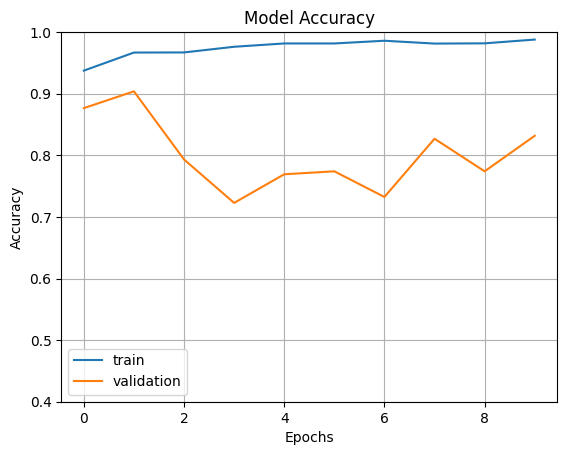

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

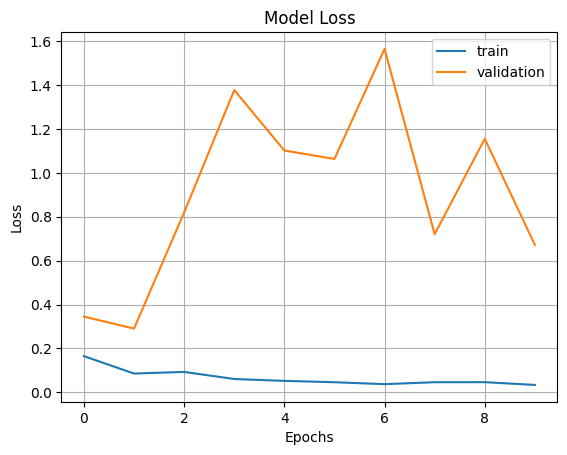

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
for images, labels in test_ds.take(1):
    predictions = VGG19_model.predict(images)
    prediction = predictions[0]
    predicted_class = np.argmax(prediction)
    print("Predicted class:", predicted_class)
    print("Predicted probabilities:", prediction)
    print("True label:", labels[0].numpy())

1/1 [==============================] - 0s 39ms/step
Predicted class: 0
Predicted probabilities: [0.55767745]
True label: 0


1/1 [==============================] - 0s 23ms/step
Confusion Matrix:
[[159  75]
 [ 10 380]]


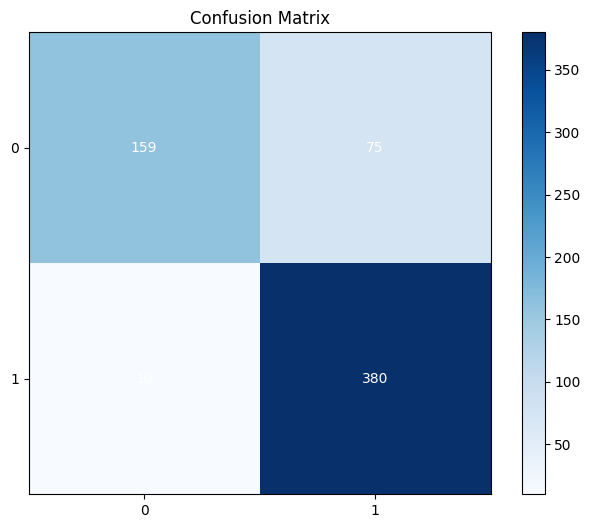

In [ ]:
from sklearn.metrics import confusion_matrix


true_labels = []
predicted_labels = []

# Threshold for classification
threshold = 0.8

for images, labels in test_ds:
    predictions = VGG19_model.predict(images)
    for prediction in predictions:
        if prediction > threshold:
            # Assign class 1
            predicted_labels.append(1)
        else:
            # Assign class 0
            predicted_labels.append(0)
    true_labels.extend(labels.numpy())

predicted_labels = np.array(predicted_labels)
# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(ticks=np.arange(conf_matrix.shape[1]), labels=[0, 1])
plt.yticks(ticks=np.arange(conf_matrix.shape[0]), labels=[0, 1])
plt.grid(False)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='white')
plt.show()



In [ ]:
resnet_model = Sequential()

pretrained_model = tf.keras.applications.ResNet50(include_top=False,
                                                  input_shape=(224, 224, 3),
                                                  pooling='avg',
                                                  classes=2,
                                                  weights='imagenet')

for layer in pretrained_model.layers:
    layer.trainable = False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(128, activation='relu'))
resnet_model.add(Dense(32, activation='relu'))
resnet_model.add(Dense(1, activation='sigmoid'))

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper_8 (ModuleWr  (None, 2048)              0         
 apper)                                                          
                                                                 
 module_wrapper_9 (ModuleWr  (None, 512)               1049088   
 apper)                                                          
                                                                 
 module_wrapper_10 (ModuleW  (None, 128)               65664     
 rapper)                                                         
                                                                 
 module_wrapper_11 (ModuleW  (None, 32)                4128      
 rapper)                                              

In [ ]:
optimizer = Adam(learning_rate=0.001)
resnet_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
epochs=10
history = resnet_model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

Epoch 1/10
163/163 [==============================] - 66s 316ms/step - loss: 0.1470 - accuracy: 0.9417 - val_loss: 0.3335 - val_accuracy: 0.8734
Epoch 2/10
163/163 [==============================] - 52s 302ms/step - loss: 0.0786 - accuracy: 0.9678 - val_loss: 0.9968 - val_accuracy: 0.7051
Epoch 3/10
163/163 [==============================] - 52s 305ms/step - loss: 0.0606 - accuracy: 0.9780 - val_loss: 0.5906 - val_accuracy: 0.8269
Epoch 4/10
163/163 [==============================] - 52s 306ms/step - loss: 0.0486 - accuracy: 0.9818 - val_loss: 1.2037 - val_accuracy: 0.7772
Epoch 5/10
163/163 [==============================] - 52s 304ms/step - loss: 0.0433 - accuracy: 0.9818 - val_loss: 0.5544 - val_accuracy: 0.8494
Epoch 6/10
163/163 [==============================] - 53s 313ms/step - loss: 0.0496 - accuracy: 0.9808 - val_loss: 1.1782 - val_accuracy: 0.7869
Epoch 7/10
163/163 [==============================] - 51s 299ms/step - loss: 0.0292 - accuracy: 0.9887 - val_loss: 2.5509 - val_ac

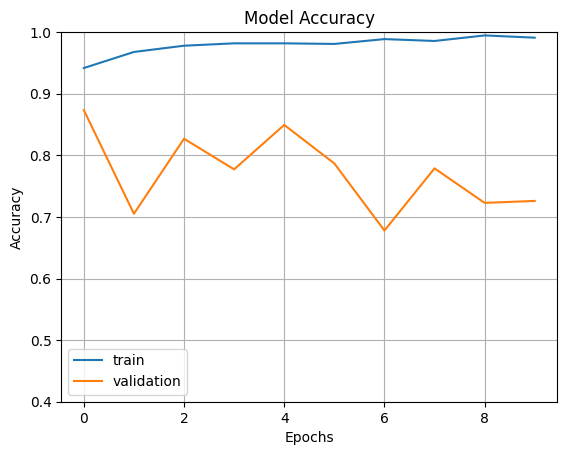

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

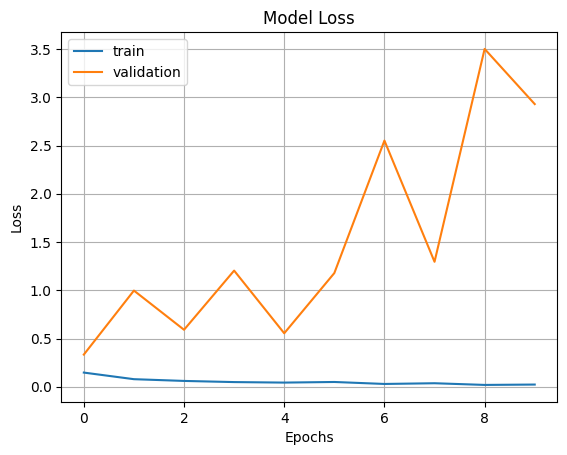

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
for images, labels in test_ds.take(1):
    predictions = resnet_model.predict(images)
    prediction = predictions[0]
    predicted_class = 1 if prediction > 0.5 else 0
    print("Predicted class:", predicted_class)
    print("Predicted probabilities:", prediction)
    print("True label:", labels[0].numpy())


1/1 [==============================] - 0s 68ms/step
Predicted class: 1
Predicted probabilities: [0.99998903]
True label: 0


1/1 [==============================] - 0s 28ms/step
Confusion Matrix:
[[ 76 158]
 [  1 389]]


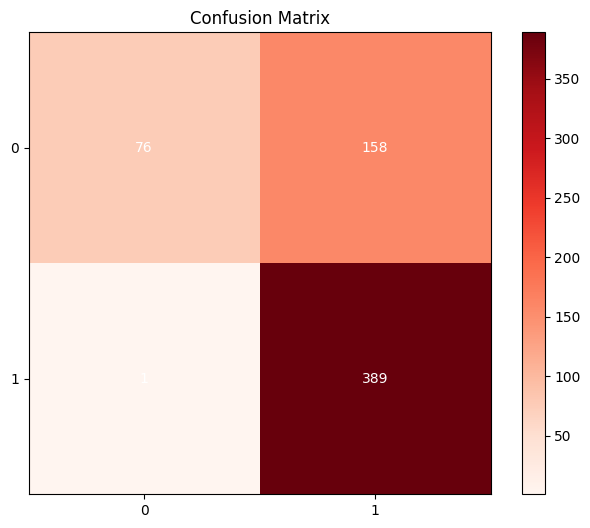

In [ ]:
true_labels = []
predicted_labels = []

# Threshold for classification
threshold = 0.8

for images, labels in test_ds:
    predictions = resnet_model.predict(images)
    for prediction in predictions:
        if prediction > threshold:
            # Assign class 1
            predicted_labels.append(1)
        else:
            # Assign class 0
            predicted_labels.append(0)
    true_labels.extend(labels.numpy())

predicted_labels = np.array(predicted_labels)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(ticks=np.arange(conf_matrix.shape[1]), labels=[0, 1])
plt.yticks(ticks=np.arange(conf_matrix.shape[0]), labels=[0, 1])
plt.grid(False)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='white')
plt.show()
